In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas.api.types import CategoricalDtype
from tableone import TableOne
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from imblearn.over_sampling import RandomOverSampler
import xgboost as xgb
import shap
from genetic_selection import GeneticSelectionCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
import statsmodels.api as sm
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
shap.initjs()

Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display


In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


### XGBoost

In [38]:
def load_data(df, label, ordinal=True, tableone=False):
    df = df.iloc[:, 4:]
    df.drop(columns='allergy_cum', inplace=True)
    df.dropna(subset=[label+'_label'], inplace=True)

    if tableone:
        columns = list(df.columns)
        categorical = ['ethnicity', 'highest_edu12', 'household_income', 'pc_vig', 'pc_mvpa', 'pg_vig', 
        'pg_mvpa', 'smoking_pg', 'passive_smoke_pc', 'passive_smoke_pg', 'delivery_mode', 'sex', 'infection_m3', 'alcohol_pc', 'alcohol_pg', 
        'antibiotics_labour', 'antibiotics_m3', 'bf_m6', 'maternal_allergy_pw11', 'cat', 'dog', 'expressway', '{}_label'.format(label)]
        groupby = [label+'_label']
        mytable = TableOne(df, columns=columns, categorical=categorical, groupby=groupby, pval=True)
        print(mytable.tabulate(tablefmt="github"))

    # df = df.fillna(df.median())
    # df['pg_mvpa'] = df['pg_mvpa'].fillna(df['pg_mvpa'].median())
    # df['ethnicity'] = df['ethnicity'].astype(int)
    df['ethnicity'] = pd.Categorical(df.ethnicity)

    if ordinal:
        # edu_type = CategoricalDtype(categories=[2, 3, 4, 5, 6], ordered=True)
        inc_type = CategoricalDtype(categories=[1, 2, 3, 4, 5], ordered=True)
        vig_type = CategoricalDtype(categories=[0, 1, 2], ordered=True)
        mvpa_type = CategoricalDtype(categories=[0.0, 1.0, 2.0, 3.0], ordered=True)
        # df['highest_edu'] = df['highest_edu'].astype(edu_type)
        df['household_income'] = df['household_income'].astype(inc_type)
        df[['pc_vig', 'pg_vig']] = df[['pc_vig', 'pg_vig']].astype(vig_type)
        df[['pc_mvpa', 'pg_mvpa']] = df[['pc_mvpa', 'pg_mvpa']].astype(mvpa_type)
    
    # print(df.head())
    y = df.loc[:, label+'_label']
    X = df.drop(label+'_label', axis=1)
    # X = df.iloc[:, :-1]
    # y = df.iloc[:, -1]
    return X, y

In [39]:
# to be edited if need different allergy outcomes
outcome = 'wheeze'

gusto = pd.read_csv('data/gusto_{}_v3.csv'.format(outcome))
gusto.loc[gusto['bf_m6'] == 99, 'bf_m6'] = np.nan
gusto.loc[gusto['ethnicity'] == 4, 'ethnicity'] = np.nan
#gusto.loc[gusto['highest_edu'] == 1, 'highest_edu'] = 2


spresto = pd.read_csv('data/spresto_{}_v3.csv'.format(outcome))
spresto.loc[spresto['bf_m6'] == 99, 'bf_m6'] = np.nan
spresto.loc[spresto['bisq_q3_m12'] == -8888, 'bisq_q3_m12'] = np.nan
spresto.loc[spresto['bisq_totslphrs_m12'] == -8888, 'bisq_totslphrs_m12'] = np.nan
spresto.loc[spresto['ethnicity'] == 4, 'ethnicity'] = np.nan
#spresto.loc[spresto['highest_edu'] == 1, 'highest_edu'] = 2
spresto['ethnicity'].fillna(99, inplace=True)
spresto['ethnicity'] = spresto['ethnicity'].astype(int)
spresto['ethnicity'] = pd.Categorical(spresto.ethnicity)
spresto.loc[spresto['ethnicity'] == 99, 'ethnicity'] = np.nan
spresto['ethnicity'] = spresto['ethnicity'].cat.remove_unused_categories()

data = pd.concat([gusto, spresto]) 
data.drop(['nicotinicacid', 'cotinine', 'hydroxycotinine'], axis=1, inplace=True)
data.drop('stai_trait_m3', axis=1, inplace=True)
print(data.shape)
data.columns

(1616, 62)


Index(['subject_id', 'eczema_cum', 'rhinitis_cum', 'wheeze_cum', 'ethnicity',
       'delivery_age', 'highest_edu12', 'household_income', 'pc_vig',
       'pc_mvpa', 'pg_vig', 'pg_mvpa', 'smoking_pg', 'passive_smoke_pc',
       'passive_smoke_pg', 'delivery_mode', 'sex', 'ga', 'stai_state_pw26',
       'stai_trait_pw26', 'stai_state_m3', 'epds_tot_pw26', 'epds_tot_m3',
       'infection_m3', 'alcohol_pc', 'alcohol_pg', 'parity', 'weight_birth',
       'antibiotics_labour', 'antibiotics_m3', 'bisq_q3_m6',
       'bisq_totslphrs_m6', 'bisq_q3_m12', 'bisq_totslphrs_m12', 'bf_m6',
       'maternal_allergy_pw11', 'cat', 'dog', 'expressway', 'allergy_cum',
       'wheeze_label', 'neopterin', 'riboflavin', 'trigonelline', 'pyridoxal',
       'pyridoxalphosphate', 'vitamind3', 'arginine', 'adma', 'creatine',
       'cystathionine', 'm3histidine', 'histidine', 'methionine',
       'hydroxyanthralinicac', 'kynurenicacid', 'kynurenine', 'tryptophan',
       'betaine', 'choline', 'dimethylglycine'

In [40]:
X, y = load_data(data, label=outcome, ordinal=True, tableone=False)
print(X.shape)
X.head()

(489, 56)


,ethnicity,delivery_age,highest_edu12,household_income,pc_vig,pc_mvpa,pg_vig,pg_mvpa,smoking_pg,passive_smoke_pc,passive_smoke_pg,delivery_mode,sex,ga,stai_state_pw26,stai_trait_pw26,stai_state_m3,epds_tot_pw26,epds_tot_m3,infection_m3,alcohol_pc,alcohol_pg,parity,weight_birth,antibiotics_labour,antibiotics_m3,bisq_q3_m6,bisq_totslphrs_m6,bisq_q3_m12,bisq_totslphrs_m12,bf_m6,maternal_allergy_pw11,cat,dog,expressway,neopterin,riboflavin,trigonelline,pyridoxal,pyridoxalphosphate,vitamind3,arginine,adma,creatine,cystathionine,m3histidine,histidine,methionine,hydroxyanthralinicac,kynurenicacid,kynurenine,tryptophan,betaine,choline,dimethylglycine,trimethylaminenoxide
0,1.0,27.84,NaN,NaN,1,1.0,1,1.0,0.0,1.0,1.0,1.0,0.0,39.57,39.0,68.0,59.0,21.0,18.0,0.0,0.0,0.0,2.0,3.030,0.0,0.0,10.0,15.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,15.6,23.80,0.282,13.10,55.4,72.0,25.3,0.384,41.4,0.2150,0.397,51.3,14.80,61.1,12.40,1.110,44.1,9.23,9.31,1.38,0.808
6,1.0,39.31,0.0,3,0,0.0,0,0.0,0.0,0.0,0.0,2.0,1.0,39.29,35.0,32.0,21.0,3.0,6.0,0.0,0.0,0.0,2.0,3.335,0.0,0.0,7.0,15.5,NaN,NaN,0.0,0.0,0.0,0.0,1.0,15.6,10.30,0.241,29.50,182.0,82.0,22.9,0.358,41.7,0.1410,0.979,60.5,16.30,93.4,12.50,1.110,49.8,11.00,9.87,1.42,0.667
20,1.0,38.98,1.0,5,2,1.0,0,1.0,0.0,0.0,0.0,2.0,0.0,38.14,33.0,39.0,29.0,3.0,2.0,0.0,0.0,NaN,2.0,2.950,0.0,0.0,8.0,10.5,NaN,NaN,1.0,0.0,0.0,0.0,0.0,22.5,13.70,0.170,10.10,61.8,100.0,21.4,0.313,42.7,0.0863,1.930,48.2,9.93,66.4,14.50,1.150,43.1,15.10,8.03,1.72,0.497
21,2.0,37.83,0.0,2,0,1.0,0,0.0,0.0,1.0,1.0,1.0,0.0,38.86,37.0,42.0,27.0,8.0,6.0,0.0,0.0,NaN,2.0,3.364,0.0,0.0,6.0,11.0,NaN,NaN,0.0,1.0,0.0,0.0,1.0,15.7,4.81,0.256,7.37,17.5,52.0,29.3,0.325,66.2,0.1780,5.410,67.2,12.70,50.0,9.47,0.752,33.0,14.40,10.90,1.87,2.150
23,3.0,28.24,1.0,4,1,1.0,0,0.0,0.0,1.0,1.0,1.0,0.0,38.43,31.0,39.0,35.0,9.0,6.0,0.0,0.0,0.0,0.0,2.440,0.0,0.0,9.0,14.0,10.0,14.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
len(X.columns)

56

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=24)
X_train.head()

,ethnicity,delivery_age,highest_edu12,household_income,pc_vig,pc_mvpa,pg_vig,pg_mvpa,smoking_pg,passive_smoke_pc,passive_smoke_pg,delivery_mode,sex,ga,stai_state_pw26,stai_trait_pw26,stai_state_m3,epds_tot_pw26,epds_tot_m3,infection_m3,alcohol_pc,alcohol_pg,parity,weight_birth,antibiotics_labour,antibiotics_m3,bisq_q3_m6,bisq_totslphrs_m6,bisq_q3_m12,bisq_totslphrs_m12,bf_m6,maternal_allergy_pw11,cat,dog,expressway,neopterin,riboflavin,trigonelline,pyridoxal,pyridoxalphosphate,vitamind3,arginine,adma,creatine,cystathionine,m3histidine,histidine,methionine,hydroxyanthralinicac,kynurenicacid,kynurenine,tryptophan,betaine,choline,dimethylglycine,trimethylaminenoxide
640,2.0,22.84,0.0,3,0,0.0,0,0.0,0.0,1.0,1.0,1.0,1.0,38.29,31.0,29.0,NaN,9.0,NaN,1.0,0.0,0.0,0.0,3.235,1.0,0.0,7.0,11.0,9.5,12.5,0.0,0.0,0.0,0.0,0.0,30.3,42.3,0.279,46.5,159.0,60.00,44.1,0.468,57.4,0.129,5.510,78.0,19.8,91.5,24.7,1.950,59.6,12.5,9.50,2.22,0.832
49,1.0,32.73,1.0,4,0,3.0,0,3.0,0.0,0.0,0.0,1.0,0.0,38.14,24.0,26.0,NaN,0.0,NaN,1.0,1.0,0.0,1.0,3.435,NaN,0.0,NaN,NaN,NaN,NaN,1.0,1.0,0.0,0.0,NaN,11.6,12.7,0.140,14.6,75.2,84.61,24.8,0.500,46.9,0.110,1.640,73.0,22.7,75.4,19.9,0.870,52.3,9.1,6.78,1.30,0.710
1119,1.0,30.63,1.0,5,1,1.0,0,1.0,0.0,0.0,0.0,1.0,0.0,38.86,30.0,27.0,22.0,0.0,4.0,0.0,0.0,0.0,0.0,2.850,0.0,0.0,10.0,12.5,10.0,12.0,1.0,0.0,0.0,0.0,0.0,13.5,22.0,0.107,65.0,311.0,103.00,33.0,0.347,47.6,0.139,5.540,77.1,20.0,65.7,21.6,0.925,45.6,11.5,8.09,1.84,1.570
56,1.0,34.41,1.0,3,0,1.0,0,0.0,0.0,0.0,0.0,2.0,1.0,39.00,22.0,28.0,23.0,0.0,0.0,0.0,0.0,0.0,1.0,3.425,0.0,0.0,8.5,11.0,9.0,10.0,1.0,1.0,0.0,0.0,0.0,17.5,46.6,0.169,10.5,57.3,148.00,18.1,0.286,67.5,0.118,1.020,54.3,11.3,78.5,10.6,0.838,38.7,11.3,9.05,1.37,1.420
407,1.0,25.14,0.0,3,2,2.0,0,0.0,0.0,0.0,0.0,1.0,0.0,38.00,22.0,NaN,21.0,3.0,1.0,0.0,1.0,0.0,1.0,2.720,1.0,0.0,13.0,15.5,10.0,12.0,1.0,1.0,0.0,0.0,0.0,17.1,9.3,0.147,32.0,212.0,98.00,19.8,0.378,49.2,0.103,0.452,73.7,11.9,65.0,21.2,1.180,40.3,14.5,10.30,4.01,0.802


In [43]:
y_train.info()

<class 'pandas.core.series.Series'>
Index: 366 entries, 640 to 604
Series name: wheeze_label
Non-Null Count  Dtype  
--------------  -----  
366 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


Eczema Parameter

In [12]:
dX= xgb.DMatrix(X, y, enable_categorical=True)
dtrain = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, y_test, enable_categorical=True)

param = {"tree_method": "approx", 'max_depth':4, 'min_child_weight': 5, 'objective':'binary:logistic', 'eval_metric': 'auc', 
"eta": 0.01, "subsample": 0.8, 'colsample_bytree': 0.9, 'gamma': 2.1, 'reg_alpha': 0.03, 'reg_lambda': 0.01,
    "base_score": np.mean(y_train)}
eval = [(dtrain, "train"), (dtest, "test")]
booster = xgb.train(param, dtrain, 1500, evals=eval, verbose_eval=20, early_stopping_rounds=120)

[0]	train-auc:0.69937	test-auc:0.60086
[20]	train-auc:0.87291	test-auc:0.60411
[40]	train-auc:0.89569	test-auc:0.62983
[60]	train-auc:0.91033	test-auc:0.63589


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[80]	train-auc:0.92125	test-auc:0.65379
[100]	train-auc:0.92767	test-auc:0.66055
[120]	train-auc:0.93583	test-auc:0.66512
[140]	train-auc:0.94263	test-auc:0.65634
[160]	train-auc:0.94921	test-auc:0.66520
[180]	train-auc:0.95613	test-auc:0.66854
[200]	train-auc:0.96045	test-auc:0.67161
[220]	train-auc:0.96506	test-auc:0.67082
[240]	train-auc:0.96834	test-auc:0.66863
[260]	train-auc:0.97093	test-auc:0.66714
[280]	train-auc:0.97458	test-auc:0.66994
[300]	train-auc:0.97675	test-auc:0.66828
[318]	train-auc:0.97924	test-auc:0.66740


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


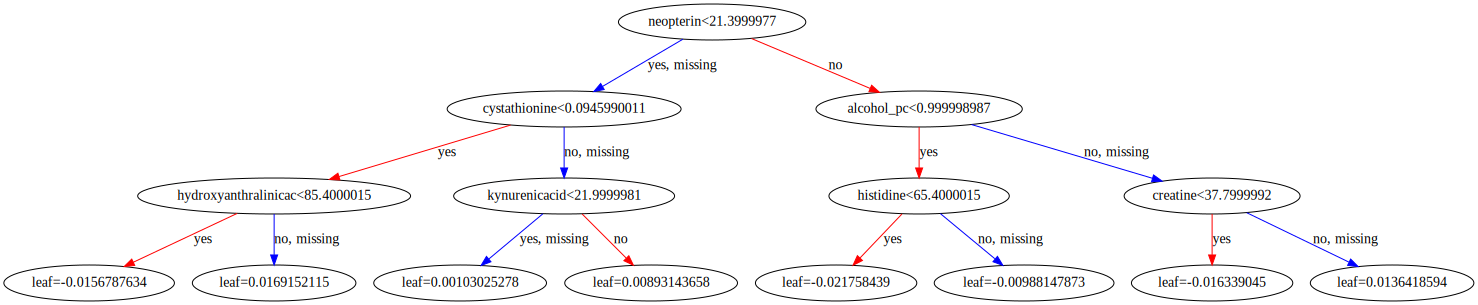

In [42]:
graph = xgb.to_graphviz(booster, num_trees=5)
graph

Rhinitis Parameters

In [101]:
dX= xgb.DMatrix(X, y, enable_categorical=True)
dtrain = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, y_test, enable_categorical=True)

param = {"tree_method": "approx", 'max_depth':3, 'min_child_weight': 3, 'objective':'binary:logistic', 'eval_metric': 'auc', 
"eta": 0.01, "subsample": 1, 'colsample_bytree': 0.7, 'gamma': 2.4, 'reg_alpha': 0, 'reg_lambda': 1,
    "base_score": np.mean(y_train)}
eval = [(dtrain, "train"), (dtest, "test")]
booster = xgb.train(param, dtrain, 1500, evals=eval, verbose_eval=20, early_stopping_rounds=30)

[0]	train-auc:0.68320	test-auc:0.52629
[20]	train-auc:0.78913	test-auc:0.59783
[40]	train-auc:0.80237	test-auc:0.61605
[60]	train-auc:0.83133	test-auc:0.64760
[80]	train-auc:0.84768	test-auc:0.66586
[100]	train-auc:0.85846	test-auc:0.67473


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[120]	train-auc:0.86816	test-auc:0.67438
[140]	train-auc:0.87591	test-auc:0.68381
[160]	train-auc:0.88173	test-auc:0.68750
[180]	train-auc:0.88933	test-auc:0.69057
[200]	train-auc:0.89699	test-auc:0.69435
[220]	train-auc:0.90151	test-auc:0.69610
[240]	train-auc:0.90462	test-auc:0.69285
[250]	train-auc:0.90655	test-auc:0.69487


Wheeze parameter

In [47]:
dX= xgb.DMatrix(X, y, enable_categorical=True)
dtrain = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, y_test, enable_categorical=True)

param = {"tree_method": "approx", 'max_depth':5, 'min_child_weight': 6, 'objective':'binary:logistic', 'eval_metric': 'auc', 
"eta": 0.01, "subsample": 0.7, 'colsample_bytree': 0.6, 'gamma': 3.4, 'reg_alpha': 0.1, 'reg_lambda': 0.3,
    "base_score": np.mean(y_train)}
eval = [(dtrain, "train"), (dtest, "test")]
booster = xgb.train(param, dtrain, 1500, evals=eval, verbose_eval=20, early_stopping_rounds=100)

[0]	train-auc:0.70516	test-auc:0.62460
[20]	train-auc:0.88368	test-auc:0.61758
[40]	train-auc:0.92539	test-auc:0.62844
[60]	train-auc:0.93663	test-auc:0.62474
[80]	train-auc:0.93885	test-auc:0.62712
[100]	train-auc:0.94411	test-auc:0.62262
[101]	train-auc:0.94516	test-auc:0.62315


In [49]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
cv_auc = xgb.cv(dtrain=dtrain, params=param, folds=cv, shuffle=True, seed=42,
                    num_boost_round=1000, early_stopping_rounds=100, metrics="auc")
cv_auc.tail()

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
850,0.978102,0.004560,0.644082,0.061736
851,0.978092,0.004551,0.644082,0.061736
852,0.978124,0.004515,0.644132,0.061712
853,0.978124,0.004519,0.644082,0.061885
854,0.978186,0.004398,0.644383,0.061846


In [51]:
cv_param = {"tree_method": "approx", 'objective':'binary:logistic', 'eval_metric': 'auc', 
"eta": 0.01, "base_score": np.mean(y_train)}

gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(3,15)
    for min_child_weight in range(1,10)
]

# Define initial best params and AUC
max_auc = 0
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    cv_param['max_depth'] = max_depth
    cv_param['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        cv_param,
        dtrain,
        num_boost_round=1000,
        seed=42,
        folds=cv,
        metrics={'auc'},
        shuffle=True,
        early_stopping_rounds=50
    )
    # Update best MAE
    mean_auc = cv_results['test-auc-mean'].max()
    boost_rounds = cv_results['test-auc-mean'].argmax()
    print("\tAUC {} for {} rounds".format(mean_auc, boost_rounds))
    if mean_auc > max_auc:
        max_auc = mean_auc
        best_params = (max_depth,min_child_weight)
print("Best params: max_depth = {}, min_child_weight = {}, AUC: {}".format(best_params[0], best_params[1], max_auc))

CV with max_depth=3, min_child_weight=1
	AUC 0.6035306000000001 for 566 rounds
CV with max_depth=3, min_child_weight=2
	AUC 0.6047735333333333 for 500 rounds
CV with max_depth=3, min_child_weight=3
	AUC 0.6017621333333333 for 583 rounds
CV with max_depth=3, min_child_weight=4
	AUC 0.6017583333333333 for 506 rounds
CV with max_depth=3, min_child_weight=5
	AUC 0.6060702666666666 for 498 rounds
CV with max_depth=3, min_child_weight=6
	AUC 0.6107730666666666 for 412 rounds
CV with max_depth=3, min_child_weight=7
	AUC 0.6221502666666666 for 551 rounds
CV with max_depth=3, min_child_weight=8
	AUC 0.6184552666666667 for 622 rounds
CV with max_depth=3, min_child_weight=9
	AUC 0.6191118000000001 for 588 rounds
CV with max_depth=4, min_child_weight=1
	AUC 0.5923476 for 373 rounds
CV with max_depth=4, min_child_weight=2
	AUC 0.5963960666666668 for 436 rounds
CV with max_depth=4, min_child_weight=3
	AUC 0.5562789333333333 for 42 rounds
CV with max_depth=4, min_child_weight=4
	AUC 0.599861133333333

In [52]:
print("Best params: {}, {}, AUC: {}".format(best_params[0], best_params[1], max_auc))

Best params: 5, 6, AUC: 0.6235935333333332


In [53]:
cv_param = {"tree_method": "approx", 'max_depth': 5, 'min_child_weight': 6, 'objective':'binary:logistic', 
'eval_metric': 'auc', "base_score": np.mean(y_train), 'eta': 0.01}

gridsearch_params = [
    (subsample, colsample_bytree)
    for subsample in [i/10. for i in range(7,11)]
    for colsample_bytree in [i/10. for i in range(6,11)]
]

# Define initial best params and AUC
max_auc = 0
best_params = None
for subsample, colsample_bytree in gridsearch_params:
    print("CV with subsample={}, colsample_bytree={}".format(
                             subsample,
                             colsample_bytree))
    # Update our parameters
    cv_param['subsample'] = subsample
    cv_param['colsample_bytree'] = colsample_bytree
    # Run CV
    cv_results = xgb.cv(
        cv_param,
        dtrain,
        num_boost_round=1000,
        seed=42,
        folds=cv,
        metrics={'auc'},
        shuffle=True,
        early_stopping_rounds=50
    )
    # Update best MAE
    mean_auc = cv_results['test-auc-mean'].max()
    boost_rounds = cv_results['test-auc-mean'].argmax()
    print("\tAUC {} for {} rounds".format(mean_auc, boost_rounds))
    if mean_auc > max_auc:
        max_auc = mean_auc
        best_params = (subsample,colsample_bytree)
print("Best params: subsample = {}, colsample_bytree = {}, AUC: {}".format(best_params[0], best_params[1], max_auc))

CV with subsample=0.7, colsample_bytree=0.6
	AUC 0.6408803333333334 for 743 rounds
CV with subsample=0.7, colsample_bytree=0.7
	AUC 0.6276151333333334 for 286 rounds
CV with subsample=0.7, colsample_bytree=0.8
	AUC 0.6402415333333333 for 590 rounds
CV with subsample=0.7, colsample_bytree=0.9
	AUC 0.6066480666666667 for 13 rounds
CV with subsample=0.7, colsample_bytree=1.0
	AUC 0.6052425333333333 for 13 rounds
CV with subsample=0.8, colsample_bytree=0.6
	AUC 0.6181249333333334 for 74 rounds
CV with subsample=0.8, colsample_bytree=0.7
	AUC 0.635049 for 571 rounds
CV with subsample=0.8, colsample_bytree=0.8
	AUC 0.6325877333333333 for 676 rounds
CV with subsample=0.8, colsample_bytree=0.9
	AUC 0.6311148000000001 for 613 rounds
CV with subsample=0.8, colsample_bytree=1.0
	AUC 0.6326328666666667 for 548 rounds
CV with subsample=0.9, colsample_bytree=0.6
	AUC 0.6218404000000001 for 266 rounds
CV with subsample=0.9, colsample_bytree=0.7
	AUC 0.6280353333333334 for 404 rounds
CV with subsample

In [54]:
cv_param = {"tree_method": "approx", 'max_depth': 5, 'min_child_weight': 6, 'objective':'binary:logistic', 'colsample_bytree': 0.6,
'subsample': 0.7, 'eval_metric': 'auc', "base_score": np.mean(y_train), 'eta': 0.01}

gridsearch_params = [
    (gamma)
    for gamma in [i/10. for i in range(0,40)]
]

# Define initial best params and AUC
max_auc = 0
best_params = None
for gamma in gridsearch_params:
    print("CV with gamma={}".format(gamma))
    # Update our parameters
    cv_param['gamma'] = gamma

    # Run CV
    cv_results = xgb.cv(
        cv_param,
        dtrain,
        num_boost_round=1000,
        seed=42,
        folds=cv,
        metrics={'auc'},
        shuffle=True,
        early_stopping_rounds=50
    )
    # Update best MAE
    mean_auc = cv_results['test-auc-mean'].max()
    boost_rounds = cv_results['test-auc-mean'].argmax()
    print("\tAUC {} for {} rounds".format(mean_auc, boost_rounds))
    if mean_auc > max_auc:
        max_auc = mean_auc
        best_params = gamma
print("Best params: gamma = {}, AUC: {}".format(best_params, max_auc))

CV with gamma=0.0
	AUC 0.6346430000000001 for 495 rounds
CV with gamma=0.1
	AUC 0.6321084666666666 for 401 rounds
CV with gamma=0.2
	AUC 0.6319052666666667 for 390 rounds
CV with gamma=0.3
	AUC 0.6310418 for 372 rounds
CV with gamma=0.4
	AUC 0.6323988666666666 for 407 rounds
CV with gamma=0.5
	AUC 0.6319864666666668 for 369 rounds
CV with gamma=0.6
	AUC 0.6316418000000001 for 373 rounds
CV with gamma=0.7
	AUC 0.6314118666666667 for 413 rounds
CV with gamma=0.8
	AUC 0.6334836666666667 for 408 rounds
CV with gamma=0.9
	AUC 0.6313616000000001 for 409 rounds
CV with gamma=1.0
	AUC 0.6336455999999999 for 393 rounds
CV with gamma=1.1
	AUC 0.6350839333333335 for 493 rounds
CV with gamma=1.2
	AUC 0.6334888000000001 for 407 rounds
CV with gamma=1.3
	AUC 0.6348512000000001 for 499 rounds
CV with gamma=1.4
	AUC 0.6346931333333334 for 495 rounds
CV with gamma=1.5
	AUC 0.6343332 for 492 rounds
CV with gamma=1.6
	AUC 0.6339270666666668 for 494 rounds
CV with gamma=1.7
	AUC 0.6340480000000001 for 407

In [55]:
cv_param = {"tree_method": "approx", 'max_depth': 5, 'min_child_weight': 6, 'colsample_bytree': 0.6, 'objective':'binary:logistic', 
'eval_metric': 'auc',"subsample": 0.7, "base_score": np.mean(y_train), 'eta': 0.01, 'gamma': 3.4}


gridsearch_params = [
    (reg_alpha, reg_lambda)
    for reg_alpha in [0, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3]
    for reg_lambda in [0, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3]
    # for reg_alpha in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
    # for reg_lambda in [1, 2, 3, 4, 5]
]

# Define initial best params and AUC
max_auc = 0
best_params = None
for reg_alpha, reg_lambda in gridsearch_params:
    print("CV with alpha={}, lambda={}".format(
                             reg_alpha,
                             reg_lambda))
    # Update our parameters
    cv_param['reg_alpha'] = reg_alpha
    cv_param['reg_lambda'] = reg_lambda
    # Run CV
    cv_results = xgb.cv(
        cv_param,
        dtrain,
        num_boost_round=1000,
        seed=42,
        folds=cv,
        metrics={'auc'},
        early_stopping_rounds=50
    )
    # Update best MAE
    # n = len(cv_results['test-auc-mean'])
    mean_auc = cv_results['test-auc-mean'].max()
    boost_rounds = cv_results['test-auc-mean'].argmax()
    print("\tAUC {} for {} rounds".format(mean_auc, boost_rounds))
    if mean_auc > max_auc:
        max_auc = mean_auc
        best_params = (reg_alpha, reg_lambda)
print("Best params: alpha = {}, lambda = {}, AUC: {}".format(best_params[0], best_params[1], max_auc))

CV with alpha=0, lambda=0
	AUC 0.6323707333333333 for 380 rounds
CV with alpha=0, lambda=0.003
	AUC 0.6391221333333333 for 620 rounds
CV with alpha=0, lambda=0.01
	AUC 0.6384821333333333 for 624 rounds
CV with alpha=0, lambda=0.03
	AUC 0.6350670666666667 for 375 rounds
CV with alpha=0, lambda=0.1
	AUC 0.6348654 for 381 rounds
CV with alpha=0, lambda=0.3
	AUC 0.6348446666666666 for 455 rounds
CV with alpha=0, lambda=1
	AUC 0.6375322666666666 for 500 rounds
CV with alpha=0, lambda=3
	AUC 0.6041750666666666 for 15 rounds
CV with alpha=0.003, lambda=0
	AUC 0.6322793999999999 for 372 rounds
CV with alpha=0.003, lambda=0.003
	AUC 0.6342637333333333 for 381 rounds
CV with alpha=0.003, lambda=0.01
	AUC 0.6349591333333332 for 460 rounds
CV with alpha=0.003, lambda=0.03
	AUC 0.6371056 for 501 rounds
CV with alpha=0.003, lambda=0.1
	AUC 0.6337201333333334 for 390 rounds
CV with alpha=0.003, lambda=0.3
	AUC 0.6351429999999999 for 449 rounds
CV with alpha=0.003, lambda=1
	AUC 0.6369384666666666 for

In [50]:
# dtest = xgb.DMatrix(X_test, y_test, enable_categorical=True)
train_pred = booster.predict(dtrain)
test_pred = booster.predict(dtest) 

print("Train AUC: %.3f" % roc_auc_score(y_train,train_pred))
print('Test AUC: %.3f' % roc_auc_score(y_test,test_pred))

Train AUC: 0.945
Test AUC: 0.624


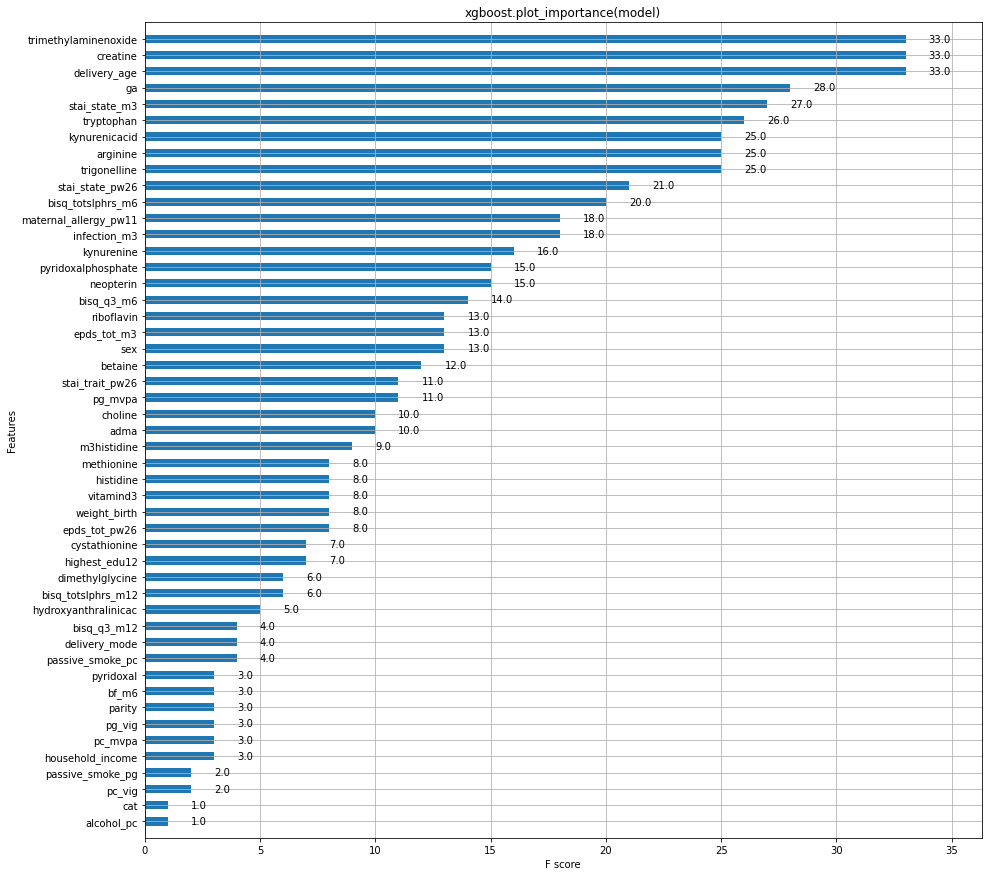

In [51]:
fig, ax = plt.subplots(figsize=(15, 15))
xgb.plot_importance(booster, ax, height=0.5)
plt.title("xgboost.plot_importance(model)")
plt.show()

In [52]:
# booster.get_score()
imp_score = list(booster.get_score().values())

data = list(zip(booster.feature_names, imp_score))
df = pd.DataFrame(data, columns=['feature', 'importance'])
df.sort_values(by='importance', ascending=False).head(15)
# df

,feature,importance
0,ethnicity,33.0
36,riboflavin,33.0
48,hydroxyanthralinicac,33.0
11,delivery_mode,28.0
14,stai_state_pw26,27.0
44,cystathionine,26.0
30,bf_m6,25.0
42,adma,25.0
34,expressway,25.0
12,sex,21.0


In [64]:
# SHAP = booster.predict(dX, pred_interactions=True)

# categorical features are listed as "c"
print(booster.feature_types)
print(booster.feature_names)

['c', 'float', 'float', 'c', 'c', 'c', 'c', 'c', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float']
['ethnicity', 'delivery_age', 'highest_edu12', 'household_income', 'pc_vig', 'pc_mvpa', 'pg_vig', 'pg_mvpa', 'smoking_pg', 'passive_smoke_pc', 'passive_smoke_pg', 'delivery_mode', 'sex', 'ga', 'stai_state_pw26', 'stai_trait_pw26', 'stai_state_m3', 'epds_tot_pw26', 'epds_tot_m3', 'infection_m3', 'alcohol_pc', 'alcohol_pg', 'parity', 'weight_birth', 'antibiotics_labour', 'antibiotics_m3', 'bisq_q3_m6', 'bisq_totslphrs_m6', 'bisq_q3_m12', 'bisq_totslphrs_m12', 'bf_m6', 'maternal_allergy_pw11', 'cat', 'dog', 'expressw

In [65]:
# make sure the SHAP values add up to marginal predictions
pred = booster.predict(dX, output_margin=True)
explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(dX)
np.abs(shap_values.sum(1) + explainer.expected_value - pred).max()

8.34465e-07

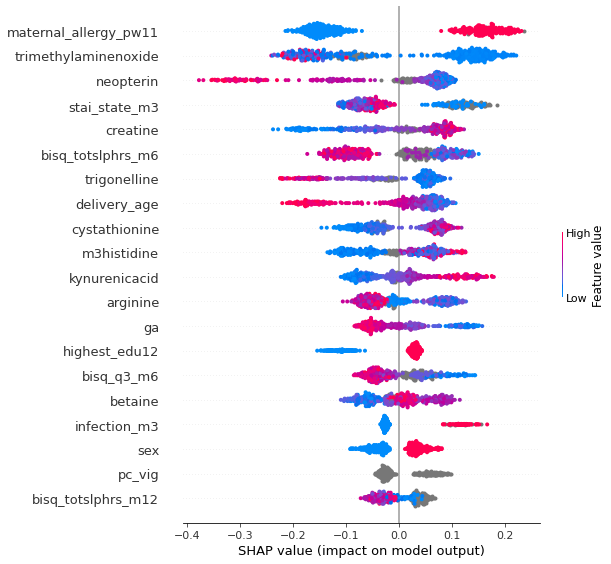

In [66]:
# use the entire dataset
shap.summary_plot(shap_values, X)

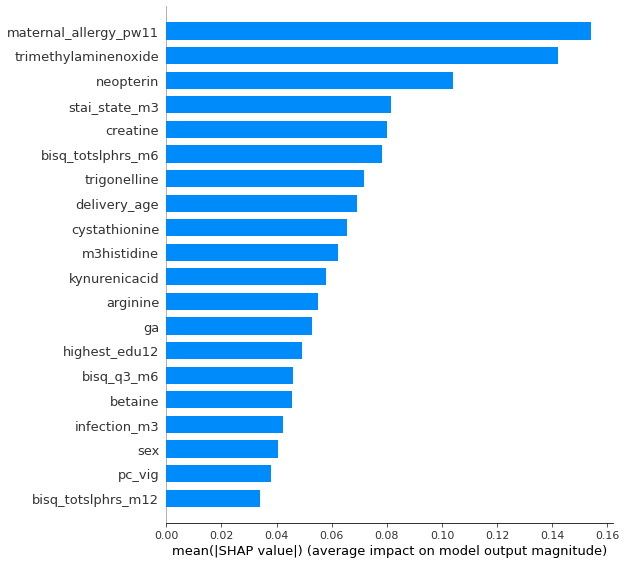

In [67]:
shap.summary_plot(shap_values, X, plot_type="bar")

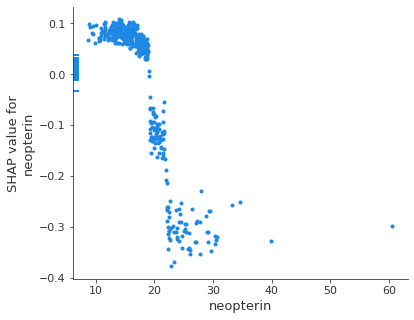

In [70]:
shap.dependence_plot('neopterin', shap_values, X, interaction_index=None, show=False)

In [71]:
rf_resultX = pd.DataFrame(shap_values, columns = X_train.columns)

vals = np.abs(rf_resultX.values).mean(0)

shap_importance = pd.DataFrame(list(zip(X_train.columns, vals)),
                                  columns=['col_name','shap_vals'])
shap_importance.sort_values(by=['shap_vals'],
                               ascending=False, inplace=True)
shap_importance.head(15)

,col_name,shap_vals
31,maternal_allergy_pw11,0.154148
55,trimethylaminenoxide,0.142225
35,neopterin,0.104003
16,stai_state_m3,0.081636
43,creatine,0.080117
27,bisq_totslphrs_m6,0.078422
37,trigonelline,0.071738
1,delivery_age,0.069143
44,cystathionine,0.065587
45,m3histidine,0.062221


### Genetic algorithm

In [61]:
def load_data(df, label, ordinal=True, tableone=False):
    df = df.iloc[:, 4:]
    df.drop(columns='allergy_cum', inplace=True)
    df.dropna(subset=[label+'_label'], inplace=True)
    df.info()

    if tableone:
        columns = list(df.columns)
        categorical = ['ethnicity', 'highest_edu12', 'household_income', 'pc_vig', 'pc_mvpa', 'pg_vig', 
        'pg_mvpa', 'smoking_pg', 'passive_smoke_pc', 'passive_smoke_pg', 'delivery_mode', 'sex', 'infection_m3', 'alcohol_pc', 'alcohol_pg', 
        'antibiotics_labour', 'antibiotics_m3', 'bf_m6', 'maternal_allergy_pw11', 'cat', 'dog', 'expressway', '{}_label'.format(label)]
        groupby = [label+'_label']
        mytable = TableOne(df, columns=columns, categorical=categorical, groupby=groupby, pval=True)
        print(mytable.tabulate(tablefmt="github"))

    cat_imp_ls = ['ethnicity', 'highest_edu12', 'household_income', 'pc_vig', 'pc_mvpa', 'pg_vig', 'pg_mvpa']
    imp = SimpleImputer(strategy="most_frequent")
    df[cat_imp_ls] = imp.fit_transform(df[cat_imp_ls])
    df.info()
    df = df.fillna(df.median())
    df.info()

    df['ethnicity'] = pd.Categorical(df.ethnicity)    
    # d = pd.get_dummies(df['ethnicity'], prefix='echnicity')
    # df = pd.concat([df, d], axis=1)
    # df = df.drop('ethnicity', axis=1)
    df[label+'_label'] = df[label+'_label'].astype(int)


    if ordinal:
        # edu_type = CategoricalDtype(categories=[2, 3, 4, 5, 6], ordered=True)
        inc_type = CategoricalDtype(categories=[1, 2, 3, 4, 5], ordered=True)
        vig_type = CategoricalDtype(categories=[0, 1, 2], ordered=True)
        mvpa_type = CategoricalDtype(categories=[0.0, 1.0, 2.0, 3.0], ordered=True)
        # df['highest_edu'] = df['highest_edu'].astype(edu_type)
        df['household_income'] = df['household_income'].astype(inc_type)
        df[['pc_vig', 'pg_vig']] = df[['pc_vig', 'pg_vig']].astype(vig_type)
        df[['pc_mvpa', 'pg_mvpa']] = df[['pc_mvpa', 'pg_mvpa']].astype(mvpa_type)
    
    # print(df.head())
    y = df.loc[:, label+'_label']
    X = df.drop(label+'_label', axis=1)
    return X, y

In [62]:
# to be edited if need different allergy outcomes
outcome = 'wheeze'

gusto = pd.read_csv('data/gusto_{}_v3.csv'.format(outcome))
gusto.loc[gusto['bf_m6'] == 99, 'bf_m6'] = np.nan
gusto.loc[gusto['ethnicity'] == 4, 'ethnicity'] = np.nan
# gusto.loc[gusto['highest_edu'] == 1, 'highest_edu'] = 2

spresto = pd.read_csv('data/spresto_{}_v3.csv'.format(outcome))
spresto.loc[spresto['bf_m6'] == 99, 'bf_m6'] = np.nan
spresto.loc[spresto['bisq_q3_m12'] == -8888, 'bisq_q3_m12'] = np.nan
spresto.loc[spresto['bisq_totslphrs_m12'] == -8888, 'bisq_totslphrs_m12'] = np.nan
spresto.loc[spresto['ethnicity'] == 4, 'ethnicity'] = np.nan
# spresto.loc[spresto['highest_edu'] == 1, 'highest_edu'] = 2
spresto['ethnicity'].fillna(99, inplace=True)
spresto['ethnicity'] = spresto['ethnicity'].astype(int)
spresto['ethnicity'] = pd.Categorical(spresto.ethnicity)
spresto.loc[spresto['ethnicity'] == 99, 'ethnicity'] = np.nan
spresto['ethnicity'] = spresto['ethnicity'].cat.remove_unused_categories()

data = pd.concat([gusto, spresto])
data.drop(['nicotinicacid', 'cotinine', 'hydroxycotinine'], axis=1, inplace=True)
data.drop('stai_trait_m3', axis=1, inplace=True)
data['delivery_mode'] = data['delivery_mode']-1
data.shape

(1616, 62)

In [63]:
data.describe()

,eczema_cum,rhinitis_cum,wheeze_cum,ethnicity,delivery_age,highest_edu12,household_income,pc_vig,pc_mvpa,pg_vig,pg_mvpa,smoking_pg,passive_smoke_pc,passive_smoke_pg,delivery_mode,sex,ga,stai_state_pw26,stai_trait_pw26,stai_state_m3,epds_tot_pw26,epds_tot_m3,infection_m3,alcohol_pc,alcohol_pg,parity,weight_birth,antibiotics_labour,antibiotics_m3,bisq_q3_m6,bisq_totslphrs_m6,bisq_q3_m12,bisq_totslphrs_m12,bf_m6,maternal_allergy_pw11,cat,dog,expressway,allergy_cum,wheeze_label,neopterin,riboflavin,trigonelline,pyridoxal,pyridoxalphosphate,vitamind3,arginine,adma,creatine,cystathionine,m3histidine,histidine,methionine,hydroxyanthralinicac,kynurenicacid,kynurenine,tryptophan,betaine,choline,dimethylglycine,trimethylaminenoxide
count,953.000000,1077.000000,907.000000,1604.000000,1536.000000,1596.000000,1463.000000,1543.000000,1545.000000,1252.000000,1254.000000,1517.000000,1500.00000,1478.000000,1511.000000,1534.000000,1536.000000,1413.000000,1409.000000,1007.000000,1440.000000,1000.000000,1326.000000,1547.000000,1497.000000,1547.000000,1519.000000,1480.000000,1336.000000,919.000000,912.000000,734.000000,733.000000,1323.000000,1574.000000,1118.000000,1123.000000,1044.000000,1151.000000,489.000000,1287.000000,1309.000000,1309.000000,1309.000000,1309.000000,1273.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1287.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,0.347324,0.660167,0.257993,1.549252,31.252591,0.753133,3.854409,0.449125,1.011650,0.035144,0.408293,0.020435,0.38400,0.342355,0.291860,0.511734,38.744694,34.508846,36.628105,34.296922,7.244444,6.434000,0.159879,0.436328,0.023380,0.732385,3.088228,0.356757,0.071108,8.552621,11.954706,9.081744,11.869975,0.504913,0.424396,0.033989,0.068566,0.143678,0.778454,0.478528,17.419347,22.385798,0.221407,28.912200,94.261688,81.249898,33.323198,0.406363,44.439292,0.157793,2.295539,68.031500,18.961951,75.935509,18.851574,1.025607,47.648663,13.173372,9.160924,1.974781,2.624998
std,0.476370,0.473872,0.437772,0.750591,4.714664,0.431324,1.110819,0.720173,0.980308,0.233921,0.775191,0.141530,0.48652,0.474658,0.454769,0.500025,1.518903,9.848899,8.946540,10.497478,4.489348,4.794855,0.366632,0.496090,0.151158,0.898902,0.455696,0.479204,0.257101,1.890055,2.687747,1.437284,1.824910,0.500165,0.494408,0.181283,0.252828,0.350931,0.415468,0.500050,4.850165,26.404309,0.254231,40.698803,66.361685,26.382597,8.591072,0.059759,11.843791,0.069093,2.284752,9.623141,4.342943,19.656037,6.714065,0.203420,7.815681,2.649487,1.623406,0.696483,4.719998
min,0.000000,0.000000,0.000000,1.000000,18.930000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,25.860000,20.000000,20.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.780000,0.000000,0.000000,2.000000,4.000000,2.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.430000,1.750000,0.010000,2.750000,8.560000,20.000000,13.600000,0.253000,13.100000,0.044000,0.078700,41.100000,9.530000,29.500000,5.220000,0.510000,19.700000,5.260000,5.380000,0.870000,0.218000
25%,0.000000,0.000000,0.000000,1.000000,28.110000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,38.140000,26.000000,30.000000,26.000000,4.000000,3.000000,0.000000,0.000000,0.000000,0.000000,2.834000,0.000000,0.000000,7.625000,10.458333,8.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,14.350000,9.600000,0.087600,10.400000,37.100000,63.000000,27.400000,0.363000,36.300000,0.110000,0.902000,61.600000,15.200000,62.300000,14.200000,0.878000,42.100000,11.300000,7.950000,1.550000,0.914000
50%,0.000000,1.000000,0.000000,1.000000,31.225000,1.000000,4.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,39.000000,34.000000,36.000000,33.000000,7.000000,6.000000,0.000000,0.000000,0.000000,1.000000,3.105000,0.000000,0.000000,9.0

In [64]:
data.head()

,subject_id,eczema_cum,rhinitis_cum,wheeze_cum,ethnicity,delivery_age,highest_edu12,household_income,pc_vig,pc_mvpa,pg_vig,pg_mvpa,smoking_pg,passive_smoke_pc,passive_smoke_pg,delivery_mode,sex,ga,stai_state_pw26,stai_trait_pw26,stai_state_m3,epds_tot_pw26,epds_tot_m3,infection_m3,alcohol_pc,alcohol_pg,parity,weight_birth,antibiotics_labour,antibiotics_m3,bisq_q3_m6,bisq_totslphrs_m6,bisq_q3_m12,bisq_totslphrs_m12,bf_m6,maternal_allergy_pw11,cat,dog,expressway,allergy_cum,wheeze_label,neopterin,riboflavin,trigonelline,pyridoxal,pyridoxalphosphate,vitamind3,arginine,adma,creatine,cystathionine,m3histidine,histidine,methionine,hydroxyanthralinicac,kynurenicacid,kynurenine,tryptophan,betaine,choline,dimethylglycine,trimethylaminenoxide
0,010-04002,0.0,1.0,1.0,1.0,27.84,NaN,NaN,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,39.57,39.0,68.0,59.0,21.0,18.0,0.0,0.0,0.0,2.0,3.030,0.0,0.0,10.0,15.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,1.0,1.0,15.6,23.80,0.2820,13.1,55.4,72.0,25.3,0.384,41.4,0.215,0.397,51.3,14.8,61.1,12.4,1.110,44.1,9.23,9.31,1.38,0.808
1,010-04004,NaN,NaN,NaN,2.0,29.98,1.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,37.29,24.0,39.0,30.0,13.0,7.0,0.0,0.0,0.0,1.0,2.825,1.0,0.0,9.0,14.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,27.7,6.24,0.3290,13.1,47.2,45.0,25.1,0.359,33.5,0.125,1.160,41.1,11.8,94.9,11.9,1.210,33.2,19.30,11.10,1.69,13.600
2,010-04006,0.0,1.0,0.0,3.0,28.10,0.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,39.71,39.0,34.0,25.0,2.0,4.0,0.0,1.0,0.0,1.0,3.925,0.0,1.0,7.0,11.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1.0,NaN,32.4,9.92,0.4860,35.3,138.0,98.0,31.1,0.483,41.4,0.116,0.278,75.5,14.9,69.6,30.4,1.370,41.5,9.15,9.42,1.74,1.240
3,010-04010,1.0,NaN,NaN,1.0,32.59,1.0,5.0,2.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,37.71,25.0,32.0,NaN,7.0,NaN,NaN,0.0,0.0,0.0,2.630,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,NaN,12.3,17.30,0.1830,186.0,191.0,131.0,56.3,0.365,62.5,0.189,21.200,70.1,28.4,58.8,11.7,0.737,48.4,12.50,6.52,1.61,6.220
4,010-04011,0.0,1.0,0.0,1.0,34.39,0.0,NaN,0.0,3.0,0.0,3.0,0.0,NaN,0.0,1.0,0.0,38.86,23.0,34.0,34.0,4.0,4.0,0.0,0.0,0.0,2.0,2.860,0.0,0.0,8.5,15.0,9.5,12.0,0.0,NaN,0.0,1.0,0.0,1.0,NaN,19.8,12.00,0.0539,30.4,146.0,107.0,21.8,0.336,48.6,0.112,1.920,57.7,12.5,72.8,12.8,0.976,46.7,16.90,8.89,1.39,0.724


In [65]:
X, y = load_data(data, label=outcome, ordinal=False, tableone=False)
print(X.shape)
X.head()

<class 'pandas.core.frame.DataFrame'>
Index: 489 entries, 0 to 373
Data columns (total 57 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ethnicity              487 non-null    float64
 1   delivery_age           489 non-null    float64
 2   highest_edu12          485 non-null    float64
 3   household_income       447 non-null    float64
 4   pc_vig                 483 non-null    float64
 5   pc_mvpa                484 non-null    float64
 6   pg_vig                 418 non-null    float64
 7   pg_mvpa                420 non-null    float64
 8   smoking_pg             482 non-null    float64
 9   passive_smoke_pc       464 non-null    float64
 10  passive_smoke_pg       463 non-null    float64
 11  delivery_mode          485 non-null    float64
 12  sex                    489 non-null    float64
 13  ga                     489 non-null    float64
 14  stai_state_pw26        456 non-null    float64
 15  stai_trait_

,ethnicity,delivery_age,highest_edu12,household_income,pc_vig,pc_mvpa,pg_vig,pg_mvpa,smoking_pg,passive_smoke_pc,passive_smoke_pg,delivery_mode,sex,ga,stai_state_pw26,stai_trait_pw26,stai_state_m3,epds_tot_pw26,epds_tot_m3,infection_m3,alcohol_pc,alcohol_pg,parity,weight_birth,antibiotics_labour,antibiotics_m3,bisq_q3_m6,bisq_totslphrs_m6,bisq_q3_m12,bisq_totslphrs_m12,bf_m6,maternal_allergy_pw11,cat,dog,expressway,neopterin,riboflavin,trigonelline,pyridoxal,pyridoxalphosphate,vitamind3,arginine,adma,creatine,cystathionine,m3histidine,histidine,methionine,hydroxyanthralinicac,kynurenicacid,kynurenine,tryptophan,betaine,choline,dimethylglycine,trimethylaminenoxide
0,1.0,27.84,1.0,5.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,39.57,39.0,68.0,59.0,21.0,18.0,0.0,0.0,0.0,2.0,3.030,0.0,0.0,10.0,15.0,9.5,12.0,0.0,0.0,0.0,0.0,0.0,15.6,23.80,0.282,13.10,55.40,72.00,25.30,0.3840,41.4,0.2150,0.397,51.30,14.80,61.1,12.40,1.110,44.1,9.23,9.310,1.38,0.808
6,1.0,39.31,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,39.29,35.0,32.0,21.0,3.0,6.0,0.0,0.0,0.0,2.0,3.335,0.0,0.0,7.0,15.5,9.5,12.0,0.0,0.0,0.0,0.0,1.0,15.6,10.30,0.241,29.50,182.00,82.00,22.90,0.3580,41.7,0.1410,0.979,60.50,16.30,93.4,12.50,1.110,49.8,11.00,9.870,1.42,0.667
20,1.0,38.98,1.0,5.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,38.14,33.0,39.0,29.0,3.0,2.0,0.0,0.0,0.0,2.0,2.950,0.0,0.0,8.0,10.5,9.5,12.0,1.0,0.0,0.0,0.0,0.0,22.5,13.70,0.170,10.10,61.80,100.00,21.40,0.3130,42.7,0.0863,1.930,48.20,9.93,66.4,14.50,1.150,43.1,15.10,8.030,1.72,0.497
21,2.0,37.83,0.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,38.86,37.0,42.0,27.0,8.0,6.0,0.0,0.0,0.0,2.0,3.364,0.0,0.0,6.0,11.0,9.5,12.0,0.0,1.0,0.0,0.0,1.0,15.7,4.81,0.256,7.37,17.50,52.00,29.30,0.3250,66.2,0.1780,5.410,67.20,12.70,50.0,9.47,0.752,33.0,14.40,10.900,1.87,2.150
23,3.0,28.24,1.0,4.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,38.43,31.0,39.0,35.0,9.0,6.0,0.0,0.0,0.0,0.0,2.440,0.0,0.0,9.0,14.0,10.0,14.0,0.0,0.0,0.0,0.0,0.0,17.0,15.60,0.136,21.15,87.85,83.87,33.05,0.3975,44.0,0.1400,1.700,67.15,19.70,73.0,17.85,1.000,47.9,12.95,8.885,1.84,1.315


In [66]:
X.columns

Index(['ethnicity', 'delivery_age', 'highest_edu12', 'household_income',
       'pc_vig', 'pc_mvpa', 'pg_vig', 'pg_mvpa', 'smoking_pg',
       'passive_smoke_pc', 'passive_smoke_pg', 'delivery_mode', 'sex', 'ga',
       'stai_state_pw26', 'stai_trait_pw26', 'stai_state_m3', 'epds_tot_pw26',
       'epds_tot_m3', 'infection_m3', 'alcohol_pc', 'alcohol_pg', 'parity',
       'weight_birth', 'antibiotics_labour', 'antibiotics_m3', 'bisq_q3_m6',
       'bisq_totslphrs_m6', 'bisq_q3_m12', 'bisq_totslphrs_m12', 'bf_m6',
       'maternal_allergy_pw11', 'cat', 'dog', 'expressway', 'neopterin',
       'riboflavin', 'trigonelline', 'pyridoxal', 'pyridoxalphosphate',
       'vitamind3', 'arginine', 'adma', 'creatine', 'cystathionine',
       'm3histidine', 'histidine', 'methionine', 'hydroxyanthralinicac',
       'kynurenicacid', 'kynurenine', 'tryptophan', 'betaine', 'choline',
       'dimethylglycine', 'trimethylaminenoxide'],
      dtype='object')

In [9]:
r_data = pd.concat([X, y], axis=1)
r_data.to_csv('./r_regression/data/{}_v3.csv'.format(outcome), index=False)
r_data.head()

,ethnicity,delivery_age,highest_edu12,household_income,pc_vig,pc_mvpa,pg_vig,pg_mvpa,smoking_pg,passive_smoke_pc,passive_smoke_pg,delivery_mode,sex,ga,stai_state_pw26,stai_trait_pw26,stai_state_m3,epds_tot_pw26,epds_tot_m3,infection_m3,alcohol_pc,alcohol_pg,parity,weight_birth,antibiotics_labour,antibiotics_m3,bisq_q3_m6,bisq_totslphrs_m6,bisq_q3_m12,bisq_totslphrs_m12,bf_m6,maternal_allergy_pw11,cat,dog,expressway,neopterin,riboflavin,trigonelline,pyridoxal,pyridoxalphosphate,vitamind3,arginine,adma,creatine,cystathionine,m3histidine,histidine,methionine,hydroxyanthralinicac,kynurenicacid,kynurenine,tryptophan,betaine,choline,dimethylglycine,trimethylaminenoxide,wheeze_label
0,1.0,27.84,1.0,5.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,39.57,39.0,68.0,59.0,21.0,18.0,0.0,0.0,0.0,2.0,3.030,0.0,0.0,10.0,15.0,9.5,12.0,0.0,0.0,0.0,0.0,0.0,15.6,23.80,0.282,13.10,55.40,72.00,25.30,0.3840,41.4,0.2150,0.397,51.30,14.80,61.1,12.40,1.110,44.1,9.23,9.310,1.38,0.808,1
6,1.0,39.31,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,39.29,35.0,32.0,21.0,3.0,6.0,0.0,0.0,0.0,2.0,3.335,0.0,0.0,7.0,15.5,9.5,12.0,0.0,0.0,0.0,0.0,1.0,15.6,10.30,0.241,29.50,182.00,82.00,22.90,0.3580,41.7,0.1410,0.979,60.50,16.30,93.4,12.50,1.110,49.8,11.00,9.870,1.42,0.667,0
20,1.0,38.98,1.0,5.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,38.14,33.0,39.0,29.0,3.0,2.0,0.0,0.0,0.0,2.0,2.950,0.0,0.0,8.0,10.5,9.5,12.0,1.0,0.0,0.0,0.0,0.0,22.5,13.70,0.170,10.10,61.80,100.00,21.40,0.3130,42.7,0.0863,1.930,48.20,9.93,66.4,14.50,1.150,43.1,15.10,8.030,1.72,0.497,0
21,2.0,37.83,0.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,38.86,37.0,42.0,27.0,8.0,6.0,0.0,0.0,0.0,2.0,3.364,0.0,0.0,6.0,11.0,9.5,12.0,0.0,1.0,0.0,0.0,1.0,15.7,4.81,0.256,7.37,17.50,52.00,29.30,0.3250,66.2,0.1780,5.410,67.20,12.70,50.0,9.47,0.752,33.0,14.40,10.900,1.87,2.150,1
23,3.0,28.24,1.0,4.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,38.43,31.0,39.0,35.0,9.0,6.0,0.0,0.0,0.0,0.0,2.440,0.0,0.0,9.0,14.0,10.0,14.0,0.0,0.0,0.0,0.0,0.0,17.0,15.60,0.136,21.15,87.85,83.87,33.05,0.3975,44.0,0.1400,1.700,67.15,19.70,73.0,17.85,1.000,47.9,12.95,8.885,1.84,1.315,1


In [67]:
cat_col = ['ethnicity', 'household_income', 'pc_vig', 'pc_mvpa', 'pg_vig', 'pg_mvpa']
X = pd.get_dummies(X, columns = cat_col, drop_first=False)
X.head()

,delivery_age,highest_edu12,smoking_pg,passive_smoke_pc,passive_smoke_pg,delivery_mode,sex,ga,stai_state_pw26,stai_trait_pw26,stai_state_m3,epds_tot_pw26,epds_tot_m3,infection_m3,alcohol_pc,alcohol_pg,parity,weight_birth,antibiotics_labour,antibiotics_m3,bisq_q3_m6,bisq_totslphrs_m6,bisq_q3_m12,bisq_totslphrs_m12,bf_m6,maternal_allergy_pw11,cat,dog,expressway,neopterin,riboflavin,trigonelline,pyridoxal,pyridoxalphosphate,vitamind3,arginine,adma,creatine,cystathionine,m3histidine,histidine,methionine,hydroxyanthralinicac,kynurenicacid,kynurenine,tryptophan,betaine,choline,dimethylglycine,trimethylaminenoxide,ethnicity_1.0,ethnicity_2.0,ethnicity_3.0,household_income_1.0,household_income_2.0,household_income_3.0,household_income_4.0,household_income_5.0,pc_vig_0.0,pc_vig_1.0,pc_vig_2.0,pc_mvpa_0.0,pc_mvpa_1.0,pc_mvpa_2.0,pc_mvpa_3.0,pg_vig_0.0,pg_vig_1.0,pg_vig_2.0,pg_mvpa_0.0,pg_mvpa_1.0,pg_mvpa_2.0,pg_mvpa_3.0
0,27.84,1.0,0.0,1.0,1.0,0.0,0.0,39.57,39.0,68.0,59.0,21.0,18.0,0.0,0.0,0.0,2.0,3.030,0.0,0.0,10.0,15.0,9.5,12.0,0.0,0.0,0.0,0.0,0.0,15.6,23.80,0.282,13.10,55.40,72.00,25.30,0.3840,41.4,0.2150,0.397,51.30,14.80,61.1,12.40,1.110,44.1,9.23,9.310,1.38,0.808,True,False,False,False,False,False,False,True,False,True,False,False,True,False,False,False,True,False,False,True,False,False
6,39.31,0.0,0.0,0.0,0.0,1.0,1.0,39.29,35.0,32.0,21.0,3.0,6.0,0.0,0.0,0.0,2.0,3.335,0.0,0.0,7.0,15.5,9.5,12.0,0.0,0.0,0.0,0.0,1.0,15.6,10.30,0.241,29.50,182.00,82.00,22.90,0.3580,41.7,0.1410,0.979,60.50,16.30,93.4,12.50,1.110,49.8,11.00,9.870,1.42,0.667,True,False,False,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,True,False,False,False
20,38.98,1.0,0.0,0.0,0.0,1.0,0.0,38.14,33.0,39.0,29.0,3.0,2.0,0.0,0.0,0.0,2.0,2.950,0.0,0.0,8.0,10.5,9.5,12.0,1.0,0.0,0.0,0.0,0.0,22.5,13.70,0.170,10.10,61.80,100.00,21.40,0.3130,42.7,0.0863,1.930,48.20,9.93,66.4,14.50,1.150,43.1,15.10,8.030,1.72,0.497,True,False,False,False,False,False,False,True,False,False,True,False,True,False,False,True,False,False,False,True,False,False
21,37.83,0.0,0.0,1.0,1.0,0.0,0.0,38.86,37.0,42.0,27.0,8.0,6.0,0.0,0.0,0.0,2.0,3.364,0.0,0.0,6.0,11.0,9.5,12.0,0.0,1.0,0.0,0.0,1.0,15.7,4.81,0.256,7.37,17.50,52.00,29.30,0.3250,66.2,0.1780,5.410,67.20,12.70,50.0,9.47,0.752,33.0,14.40,10.900,1.87,2.150,False,True,False,False,True,False,False,False,True,False,False,False,True,False,False,True,False,False,True,False,False,False
23,28.24,1.0,0.0,1.0,1.0,0.0,0.0,38.43,31.0,39.0,35.0,9.0,6.0,0.0,0.0,0.0,0.0,2.440,0.0,0.0,9.0,14.0,10.0,14.0,0.0,0.0,0.0,0.0,0.0,17.0,15.60,0.136,21.15,87.85,83.87,33.05,0.3975,44.0,0.1400,1.700,67.15,19.70,73.0,17.85,1.000,47.9,12.95,8.885,1.84,1.315,False,False,True,False,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False


In [68]:
pd.set_option('display.max_columns', None)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=24)
X_train.describe()

,delivery_age,highest_edu12,smoking_pg,passive_smoke_pc,passive_smoke_pg,delivery_mode,sex,ga,stai_state_pw26,stai_trait_pw26,stai_state_m3,epds_tot_pw26,epds_tot_m3,infection_m3,alcohol_pc,alcohol_pg,parity,weight_birth,antibiotics_labour,antibiotics_m3,bisq_q3_m6,bisq_totslphrs_m6,bisq_q3_m12,bisq_totslphrs_m12,bf_m6,maternal_allergy_pw11,cat,dog,expressway,neopterin,riboflavin,trigonelline,pyridoxal,pyridoxalphosphate,vitamind3,arginine,adma,creatine,cystathionine,m3histidine,histidine,methionine,hydroxyanthralinicac,kynurenicacid,kynurenine,tryptophan,betaine,choline,dimethylglycine,trimethylaminenoxide
count,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.00000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.0000,366.000000,366.000000,366.000000
mean,31.798798,0.775956,0.021858,0.352459,0.303279,0.319672,0.519126,38.764399,34.377049,36.448087,33.404372,7.183060,5.904372,0.150273,0.374317,0.027322,0.830601,3.090478,0.336066,0.057377,8.681899,12.044945,9.318761,11.990483,0.453552,0.434426,0.030055,0.04918,0.109290,17.569262,21.112760,0.195461,27.505219,99.250683,85.385273,32.678142,0.399850,45.054098,0.152086,2.208975,67.305191,18.683689,74.796995,18.819235,1.025850,47.890164,13.0850,9.141311,1.905109,2.609962
std,4.796241,0.417522,0.146420,0.478390,0.460304,0.466988,0.500318,1.604092,9.719345,8.968822,8.863988,4.589068,4.167603,0.357828,0.484609,0.163244,0.944338,0.461872,0.473008,0.232880,1.659828,2.343374,1.081380,1.273130,0.498519,0.496360,0.170971,0.21654,0.312429,4.144267,20.500085,0.211730,37.353566,68.620024,23.734819,7.682497,0.055399,11.251256,0.061998,1.870387,8.467940,3.809417,17.338622,6.234067,0.205401,7.283425,2.3942,1.545628,0.529339,5.662196
min,19.590000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.860000,20.000000,20.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.780000,0.000000,0.000000,2.500000,4.000000,4.500000,6.333333,0.000000,0.000000,0.000000,0.00000,0.000000,8.660000,2.320000,0.020000,4.470000,9.340000,20.000000,13.600000,0.275000,17.500000,0.049100,0.150000,44.900000,9.930000,35.500000,6.910000,0.573000,26.100000,6.4800,6.020000,0.940000,0.410000
25%,28.515000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,38.140000,26.000000,30.000000,29.000000,4.000000,3.000000,0.000000,0.000000,0.000000,0.000000,2.826750,0.000000,0.000000,8.000000,11.000000,9.000000,12.000000,0.000000,0.000000,0.000000,0.00000,0.000000,15.100000,10.325000,0.094850,11.825000,42.900000,73.000000,27.800000,0.365250,37.950000,0.114000,0.952250,62.100000,15.300000,63.125000,14.625000,0.893000,43.300000,11.5000,8.110000,1.560000,0.960000
50%,31.770000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,39.000000,34.000000,36.000000,32.000000,7.000000,5.000000,0.000000,0.000000,0.000000,1.000000,3.110000,0.000000,0.000000,9.000000,12.000000,9.500000,12.000000,0.000000,0.000000,0.000000,0.00000,0.000000,17.000000,15.600000,0.136000,21.150000,87.850000,83.870000,33.050000,0.397500,44.000000,0.140000,1.700000,67.150000,19.700000,73.000000,17.850000,1.000000,47.900000,12.9500,8.885000,1.840000,1.315000
75%,35.230000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,39.822500,41.000000,42.000000,38.000000,10.000000,8.000000,0.000000,1.000000,0.000000,1.000000,3.378750,1.000000,0.000000,9.500000,13.500000,10.000000,12.500000,1.000000,1.000000,0.000000,0.00000,0.000000,19.300000,22.975000,0.223750,32.575000,135.750000,98.750000,36.800000,0.433000,50.450000,0.170000,2.720000,72.575000,21.300000,82.900000,21.550000,1.120000,51.675000,14.4750,9.957500,2.140000,2.045000
max,44.510000,1.000000,1.

In [29]:
sd = StandardScaler()
X_train_sc = sd.fit_transform(X_train)
X_test_sc = sd.transform(X_test)

In [30]:
pd.DataFrame(X_train_sc, columns=X.columns).describe()

,delivery_age,highest_edu12,smoking_pg,passive_smoke_pc,passive_smoke_pg,delivery_mode,sex,ga,stai_state_pw26,stai_trait_pw26,stai_state_m3,epds_tot_pw26,epds_tot_m3,infection_m3,alcohol_pc,alcohol_pg,parity,weight_birth,antibiotics_labour,antibiotics_m3,bisq_q3_m6,bisq_totslphrs_m6,bisq_q3_m12,bisq_totslphrs_m12,bf_m6,maternal_allergy_pw11,cat,dog,expressway,neopterin,riboflavin,trigonelline,pyridoxal,pyridoxalphosphate,vitamind3,arginine,adma,creatine,cystathionine,m3histidine,histidine,methionine,hydroxyanthralinicac,kynurenicacid,kynurenine,tryptophan,betaine,choline,dimethylglycine,trimethylaminenoxide,ethnicity_1.0,ethnicity_2.0,ethnicity_3.0,household_income_1.0,household_income_2.0,household_income_3.0,household_income_4.0,household_income_5.0,pc_vig_0.0,pc_vig_1.0,pc_vig_2.0,pc_mvpa_0.0,pc_mvpa_1.0,pc_mvpa_2.0,pc_mvpa_3.0,pg_vig_0.0,pg_vig_1.0,pg_vig_2.0,pg_mvpa_0.0,pg_mvpa_1.0,pg_mvpa_2.0,pg_mvpa_3.0
count,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,366.000000,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02
mean,1.698702e-17,7.765494e-17,-4.853434e-18,-1.213358e-17,-5.824121e-17,-3.397404e-17,-7.522823e-17,1.201225e-16,9.221525e-17,3.761411e-16,1.164824e-16,2.912060e-17,-8.250838e-17,-1.067755e-16,-7.765494e-17,5.096106e-17,-6.794808e-17,6.406533e-16,-9.706868e-18,-1.213358e-17,4.416625e-16,-5.557182e-16,-1.650168e-16,-5.338777e-16,2.912060e-17,1.274026e-17,0.000000,-4.853434e-17,-4.853434e-18,-2.184045e-16,-2.912060e-17,-3.882747e-17,5.824121e-17,-1.116290e-16,6.794808e-17,-3.251801e-16,-4.234621e-16,-2.960595e-16,1.553099e-16,-7.522823e-17,1.844305e-16,-4.319556e-16,-9.464196e-17,3.858480e-16,-4.868601e-16,-1.038635e-15,-5.047571e-16,9.512731e-16,2.620854e-16,-1.213358e-17,-3.882747e-17,-8.736181e-17,2.184045e-17,2.184045e-17,4.853434e-17,-5.338777e-17,-3.640075e-17,-2.912060e-17,-2.912060e-17,3.882747e-17,-3.640075e-18,3.397404e-17,-2.912060e-17,9.464196e-17,1.941374e-17,1.722969e-16,2.426717e-18,4.853434e-18,-1.213358e-16,2.912060e-17,2.912060e-17,4.853434e-18
std,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00
min,-2.303261e+00,-1.875771e+00,-1.396374e-01,-7.599909e-01,-6.854776e-01,-6.597682e-01,-1.044715e+00,-8.364863e+00,-1.446666e+00,-1.891885e+00,-1.529688e+00,-1.609683e+00,-1.422314e+00,-3.977786e-01,-7.555233e-01,-1.760282e

In [31]:
estimator = LogisticRegression(max_iter=1e5)

selector = GeneticSelectionCV(
    estimator,
    cv=5,
    verbose=1,
    scoring="roc_auc",
    max_features=None,
    n_population=80,
    crossover_proba=0.5,
    mutation_proba=0.2,
    n_generations=100,
    crossover_independent_proba=0.5,
    mutation_independent_proba=0.04,
    tournament_size=3,
    n_gen_no_change=20,
    caching=True,
    n_jobs=-1,
)
selector = selector.fit(X_train_sc, y_train)

Selecting features with genetic algorithm.
gen	nevals	avg                               	std                               	min                            	max                               
0  	80    	[  0.564506  35.25       0.05622 ]	[  0.028528  22.817482   0.016252]	[ 0.495483  1.        0.007448]	[  0.651043  72.         0.09185 ]
1  	48    	[  0.589844  42.9875     0.05989 ]	[  0.022942  19.579003   0.013438]	[ 0.546119  1.        0.019008]	[  0.651043  72.         0.086464]
2  	43    	[  0.608909  35.55       0.057255]	[  0.024549  16.010075   0.01652 ]	[ 0.562784  6.        0.018751]	[  0.677644  72.         0.085282]
3  	39    	[  0.629136  27.425      0.051742]	[  0.023107  12.313382   0.016872]	[ 0.561943  6.        0.022274]	[  0.677644  50.         0.087087]
4  	60    	[  0.64091   21.4625     0.045885]	[ 0.019132  8.580419  0.012084]   	[ 0.590472  9.        0.026671]	[  0.677644  44.         0.084611]
5  	44    	[  0.653936  19.8875     0.042664]	[ 0.014433  6.505755  0

In [32]:
print(selector.support_)
print(selector.n_features_)
print(selector.generation_scores_)

[False  True False  True False False False  True False  True False  True
 False  True  True  True False False False False False  True False False
 False False False False False  True False  True False False  True False
 False False  True  True False False  True False False False False False
  True False  True  True  True False False False  True False False  True
 False False  True  True False False False False False False False False]
23
[0.65104299 0.65104299 0.67764411 0.67764411 0.67764411 0.67764411
 0.68338153 0.68537498 0.68587623 0.68980528 0.69468286 0.69545402
 0.69911317 0.70316946 0.70407557 0.7071872  0.7071872  0.7071872
 0.7071872  0.70733757 0.70763833 0.70763833 0.70763833 0.70763833
 0.70763833 0.70763833 0.70763833 0.7094197  0.7094197  0.7094197
 0.7094197  0.71106613 0.71106613 0.71106613 0.71106613 0.71106613
 0.71106613 0.71106613 0.71106613 0.71106613 0.71106613 0.71106613
 0.71106613 0.71106613 0.71106613 0.71106613 0.71106613 0.71106613
 0.71106613 0.71106613 0

In [33]:
print('train AUC:', selector.score(X_train_sc, y_train))
print('test AUC:', selector.score(X_test_sc, y_test))

train AUC: 0.6857923497267759
test AUC: 0.6260162601626016


In [34]:
pd.DataFrame(X.columns[selector.support_])

,0
0,highest_edu12
1,passive_smoke_pc
2,ga
3,stai_trait_pw26
4,epds_tot_pw26
5,infection_m3
6,alcohol_pc
7,alcohol_pg
8,bisq_totslphrs_m6
9,neopterin


### Logistic Regression

In [103]:
pd.set_option('display.max_columns', None)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=24)
X_train.describe()

,delivery_age,highest_edu12,smoking_pg,passive_smoke_pc,passive_smoke_pg,delivery_mode,sex,ga,stai_state_pw26,stai_trait_pw26,stai_state_m3,epds_tot_pw26,epds_tot_m3,infection_m3,alcohol_pc,alcohol_pg,parity,weight_birth,antibiotics_labour,antibiotics_m3,bisq_q3_m6,bisq_totslphrs_m6,bisq_q3_m12,bisq_totslphrs_m12,bf_m6,maternal_allergy_pw11,cat,dog,expressway,neopterin,riboflavin,trigonelline,pyridoxal,pyridoxalphosphate,vitamind3,arginine,adma,creatine,cystathionine,m3histidine,histidine,methionine,hydroxyanthralinicac,kynurenicacid,kynurenine,tryptophan,betaine,choline,dimethylglycine,trimethylaminenoxide
count,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.00000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.0000,366.000000,366.000000,366.000000
mean,31.798798,0.775956,0.021858,0.352459,0.303279,0.319672,0.519126,38.764399,34.377049,36.448087,33.404372,7.183060,5.904372,0.150273,0.374317,0.027322,0.830601,3.090478,0.336066,0.057377,8.681899,12.044945,9.318761,11.990483,0.453552,0.434426,0.030055,0.04918,0.109290,17.569262,21.112760,0.195461,27.505219,99.250683,85.385273,32.678142,0.399850,45.054098,0.152086,2.208975,67.305191,18.683689,74.796995,18.819235,1.025850,47.890164,13.0850,9.141311,1.905109,2.609962
std,4.796241,0.417522,0.146420,0.478390,0.460304,0.466988,0.500318,1.604092,9.719345,8.968822,8.863988,4.589068,4.167603,0.357828,0.484609,0.163244,0.944338,0.461872,0.473008,0.232880,1.659828,2.343374,1.081380,1.273130,0.498519,0.496360,0.170971,0.21654,0.312429,4.144267,20.500085,0.211730,37.353566,68.620024,23.734819,7.682497,0.055399,11.251256,0.061998,1.870387,8.467940,3.809417,17.338622,6.234067,0.205401,7.283425,2.3942,1.545628,0.529339,5.662196
min,19.590000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.860000,20.000000,20.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.780000,0.000000,0.000000,2.500000,4.000000,4.500000,6.333333,0.000000,0.000000,0.000000,0.00000,0.000000,8.660000,2.320000,0.020000,4.470000,9.340000,20.000000,13.600000,0.275000,17.500000,0.049100,0.150000,44.900000,9.930000,35.500000,6.910000,0.573000,26.100000,6.4800,6.020000,0.940000,0.410000
25%,28.515000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,38.140000,26.000000,30.000000,29.000000,4.000000,3.000000,0.000000,0.000000,0.000000,0.000000,2.826750,0.000000,0.000000,8.000000,11.000000,9.000000,12.000000,0.000000,0.000000,0.000000,0.00000,0.000000,15.100000,10.325000,0.094850,11.825000,42.900000,73.000000,27.800000,0.365250,37.950000,0.114000,0.952250,62.100000,15.300000,63.125000,14.625000,0.893000,43.300000,11.5000,8.110000,1.560000,0.960000
50%,31.770000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,39.000000,34.000000,36.000000,32.000000,7.000000,5.000000,0.000000,0.000000,0.000000,1.000000,3.110000,0.000000,0.000000,9.000000,12.000000,9.500000,12.000000,0.000000,0.000000,0.000000,0.00000,0.000000,17.000000,15.600000,0.136000,21.150000,87.850000,83.870000,33.050000,0.397500,44.000000,0.140000,1.700000,67.150000,19.700000,73.000000,17.850000,1.000000,47.900000,12.9500,8.885000,1.840000,1.315000
75%,35.230000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,39.822500,41.000000,42.000000,38.000000,10.000000,8.000000,0.000000,1.000000,0.000000,1.000000,3.378750,1.000000,0.000000,9.500000,13.500000,10.000000,12.500000,1.000000,1.000000,0.000000,0.00000,0.000000,19.300000,22.975000,0.223750,32.575000,135.750000,98.750000,36.800000,0.433000,50.450000,0.170000,2.720000,72.575000,21.300000,82.900000,21.550000,1.120000,51.675000,14.4750,9.957500,2.140000,2.045000
max,44.510000,1.000000,1.

In [104]:
sd = StandardScaler()
X_train_sc = sd.fit_transform(X_train)
X_test_sc = sd.transform(X_test)
X_sc = sd.transform(X)

In [105]:
model = sm.GLM(np.array(y_train), sm.add_constant(pd.DataFrame(X_train_sc, columns=X_train.columns)))
results = model.fit()
print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  366
Model:                            GLM   Df Residuals:                      299
Model Family:                Gaussian   Df Model:                           66
Link Function:               identity   Scale:                         0.25724
Method:                          IRLS   Log-Likelihood:                -215.45
Date:                Thu, 25 May 2023   Deviance:                       69.552
Time:                        12:52:45   Pearson chi2:                     69.6
No. Iterations:                     3   Pseudo R-squ. (CS):             0.2388
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.47

In [106]:
# dtest = xgb.DMatrix(X_test, y_test, enable_categorical=True)
train_pred = results.predict(sm.add_constant(pd.DataFrame(X_train_sc, columns=X_train.columns), has_constant='add'))
test_pred = results.predict(sm.add_constant(pd.DataFrame(X_test_sc, columns=X_train.columns), has_constant='add'))

print("train AUC: %.3f" % roc_auc_score(y_train,train_pred))
print("test AUC: %.3f" % roc_auc_score(y_test,test_pred))

train AUC: 0.784
test AUC: 0.630


In [107]:
def results_summary_to_dataframe(results):
    '''take the result of an statsmodel results table and transforms it into a dataframe'''
    pvals = results.pvalues
    coeff = results.params
    OR = np.exp(coeff)
    coef_lower = results.conf_int()[0]
    coef_upper = results.conf_int()[1]
    or_lower = np.exp(results.conf_int()[0])
    or_upper = np.exp(results.conf_int()[1])

    results_df = pd.DataFrame({"pvals":pvals,
                               "coeff":coeff,
                                "Odds ratio": OR,
                                "coef lower": coef_lower,
                                "coef upper": coef_upper,
                               "or lower":or_lower,
                               "or upper":or_upper
                                })

    #Reordering...
    results_df = results_df[["coeff", "Odds ratio", "pvals","coef lower","coef upper", "or lower", "or upper"]]
    return results_df.round(3)

In [108]:
table = results_summary_to_dataframe(results)
table = table.reset_index()
table.sort_values(by='pvals', ascending=True).loc[:, ['index', 'coeff', 'pvals']].head(15)

,index,coeff,pvals
0,const,0.478,0.000
2,highest_edu12,0.089,0.013
7,sex,0.067,0.023
14,infection_m3,0.061,0.052
30,neopterin,-0.067,0.055
68,pg_vig_2.0,0.058,0.062
44,kynurenicacid,0.069,0.064
23,bisq_q3_m12,0.069,0.109
12,epds_tot_pw26,0.067,0.111
38,creatine,0.050,0.126
